In [12]:
# 필요한 라이브러리 임포트
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [13]:
# 맥북 시각화 한글 폰트 설정
import matplotlib.font_manager as fm

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 폰트 정상 설정 확인
print(plt.rcParams['font.family'])

['AppleGothic']


In [14]:
# 함수

# 데이터 다운로드 함수
def download_data(tickers):
    end_date = datetime.now()
    data_dict = {}
    for ticker in tickers:
        data = yf.download(ticker, start='2000-01-01', end=end_date)
        data_dict[ticker] = data
    
    start_dates = [data.index[0] for data in data_dict.values()]
    latest_start = max(start_dates)
    
    prices = pd.DataFrame()
    for ticker in tickers:
        data = data_dict[ticker]['Adj Close'][latest_start:]
        prices[ticker] = data
    
    return prices

# 포트폴리오 성과 계산 함수 정의
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_risk

# 포트폴리오 최적화 함수 정의
def optimize_portfolio(returns, target_return):
    n_assets = len(returns.columns)
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(returns.mean() * x) * 252 - target_return}
    )
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.array([1/n_assets] * n_assets)
    
    result = minimize(portfolio_volatility, initial_weights, 
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 백테스트 함수 정의
def backtest_portfolio(prices, weights):
    returns = prices.pct_change().dropna()
    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return cumulative_returns


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


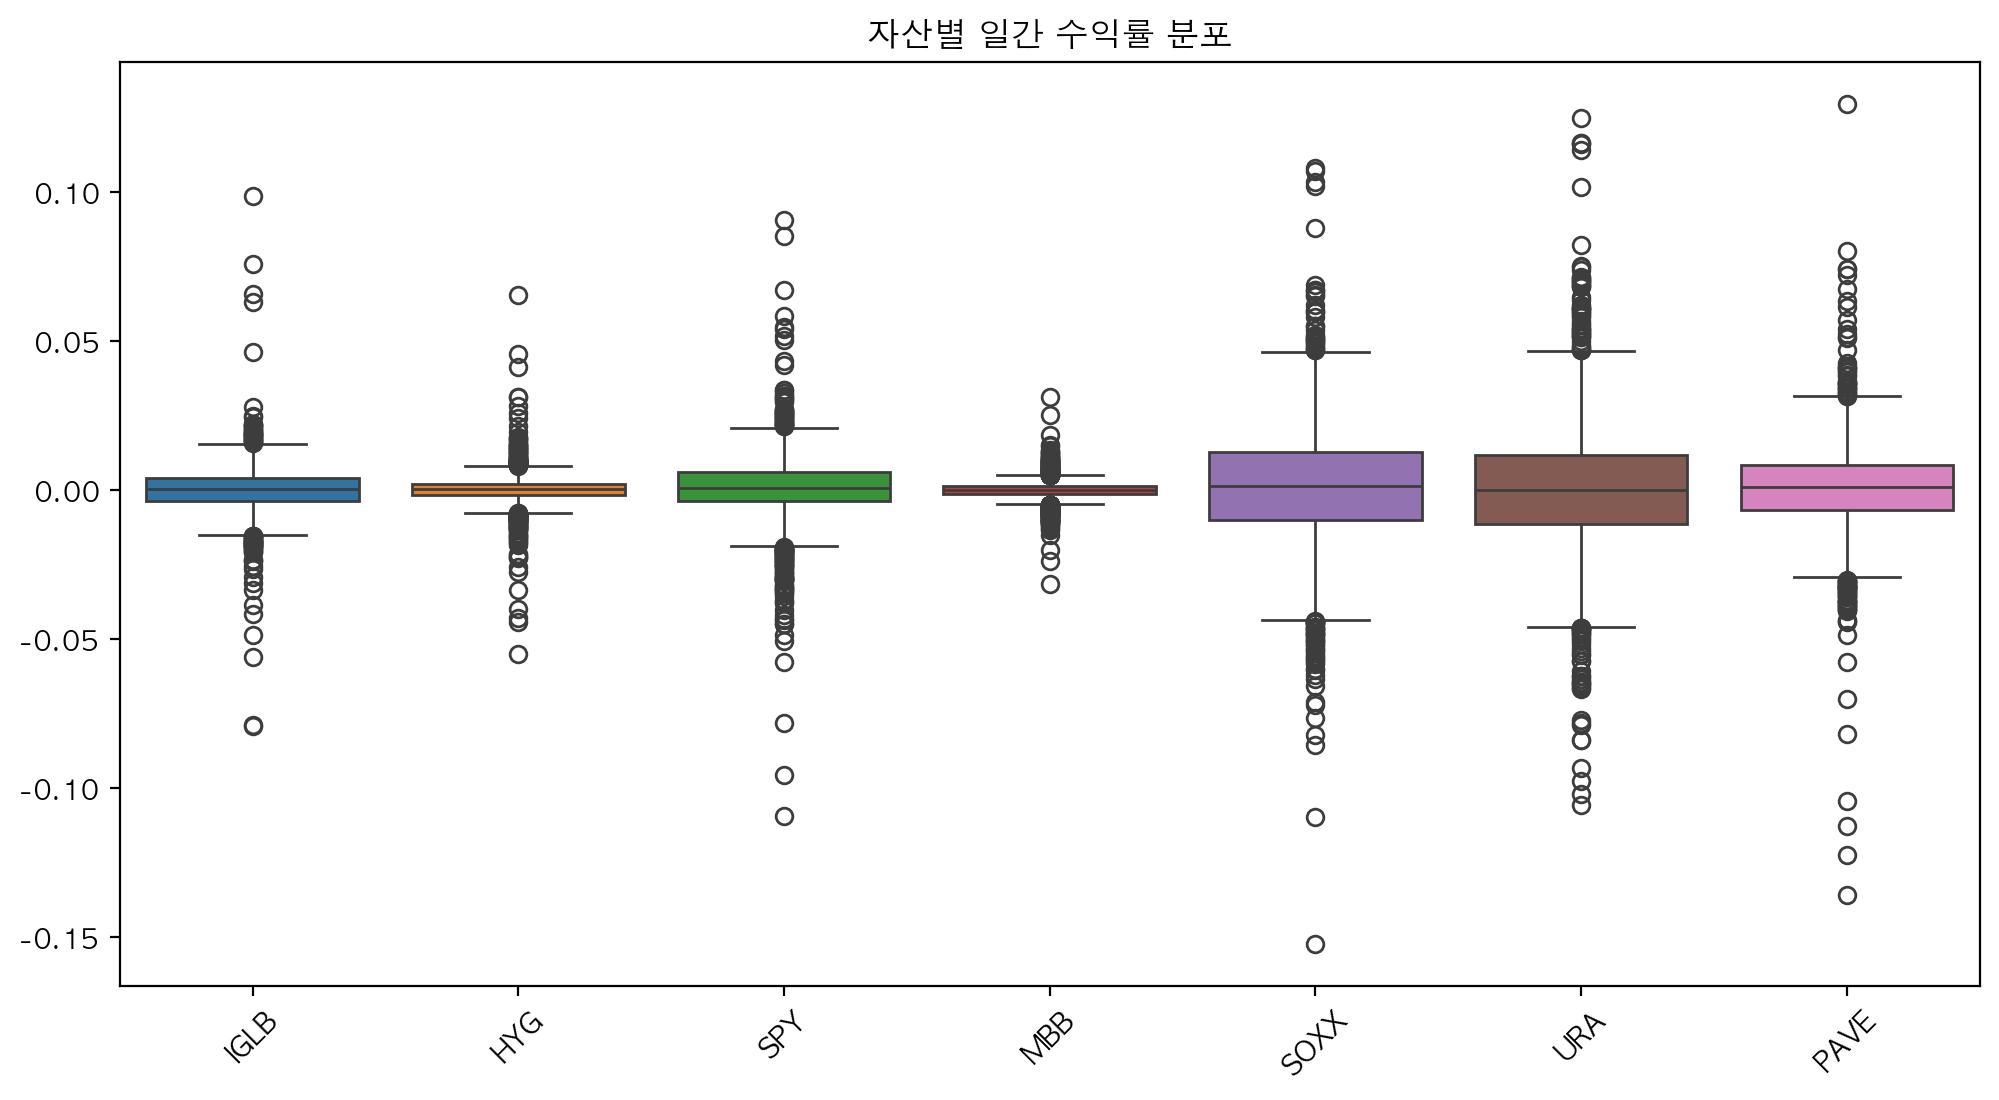

In [15]:
# 분석할 티커 설정
tickers = ['IGLB', 'HYG', 'SPY', 'MBB', 'SOXX', 'URA', 'PAVE']

# 데이터 다운로드 실행
prices = download_data(tickers)
returns = prices.pct_change().dropna()

# 첫 번째 시각화: 자산별 수익률 분포
plt.figure(figsize=(12, 6))
sns.boxplot(data=returns)
plt.title('자산별 일간 수익률 분포')
plt.xticks(rotation=45)
plt.show()


In [16]:
# 효율적 투자선 계산
n_portfolios = 1000
returns_array = np.linspace(returns.mean().min() * 252, returns.mean().max() * 252, n_portfolios)
risk_array = []
weights_array = []

for target_return in returns_array:
    weights = optimize_portfolio(returns, target_return)
    _, risk = calculate_portfolio_performance(weights, returns)
    risk_array.append(risk)
    weights_array.append(weights)

# 리스크 수준별 포트폴리오 선택
risk_levels = {
    '저위험': int(n_portfolios * 0.2),
    '중위험': int(n_portfolios * 0.5),
    '고위험': int(n_portfolios * 0.8)
}

# 포트폴리오 구성 및 백테스트
portfolios = {}
for risk_level, idx in risk_levels.items():
    weights = weights_array[idx]
    portfolios[risk_level] = {
        'weights': weights,
        'return': returns_array[idx],
        'risk': risk_array[idx],
        'backtest': backtest_portfolio(prices, weights)
    }

# S&P500 성과 계산
spy_returns = prices['SPY'].pct_change().dropna()
spy_cumulative = (1 + spy_returns).cumprod()

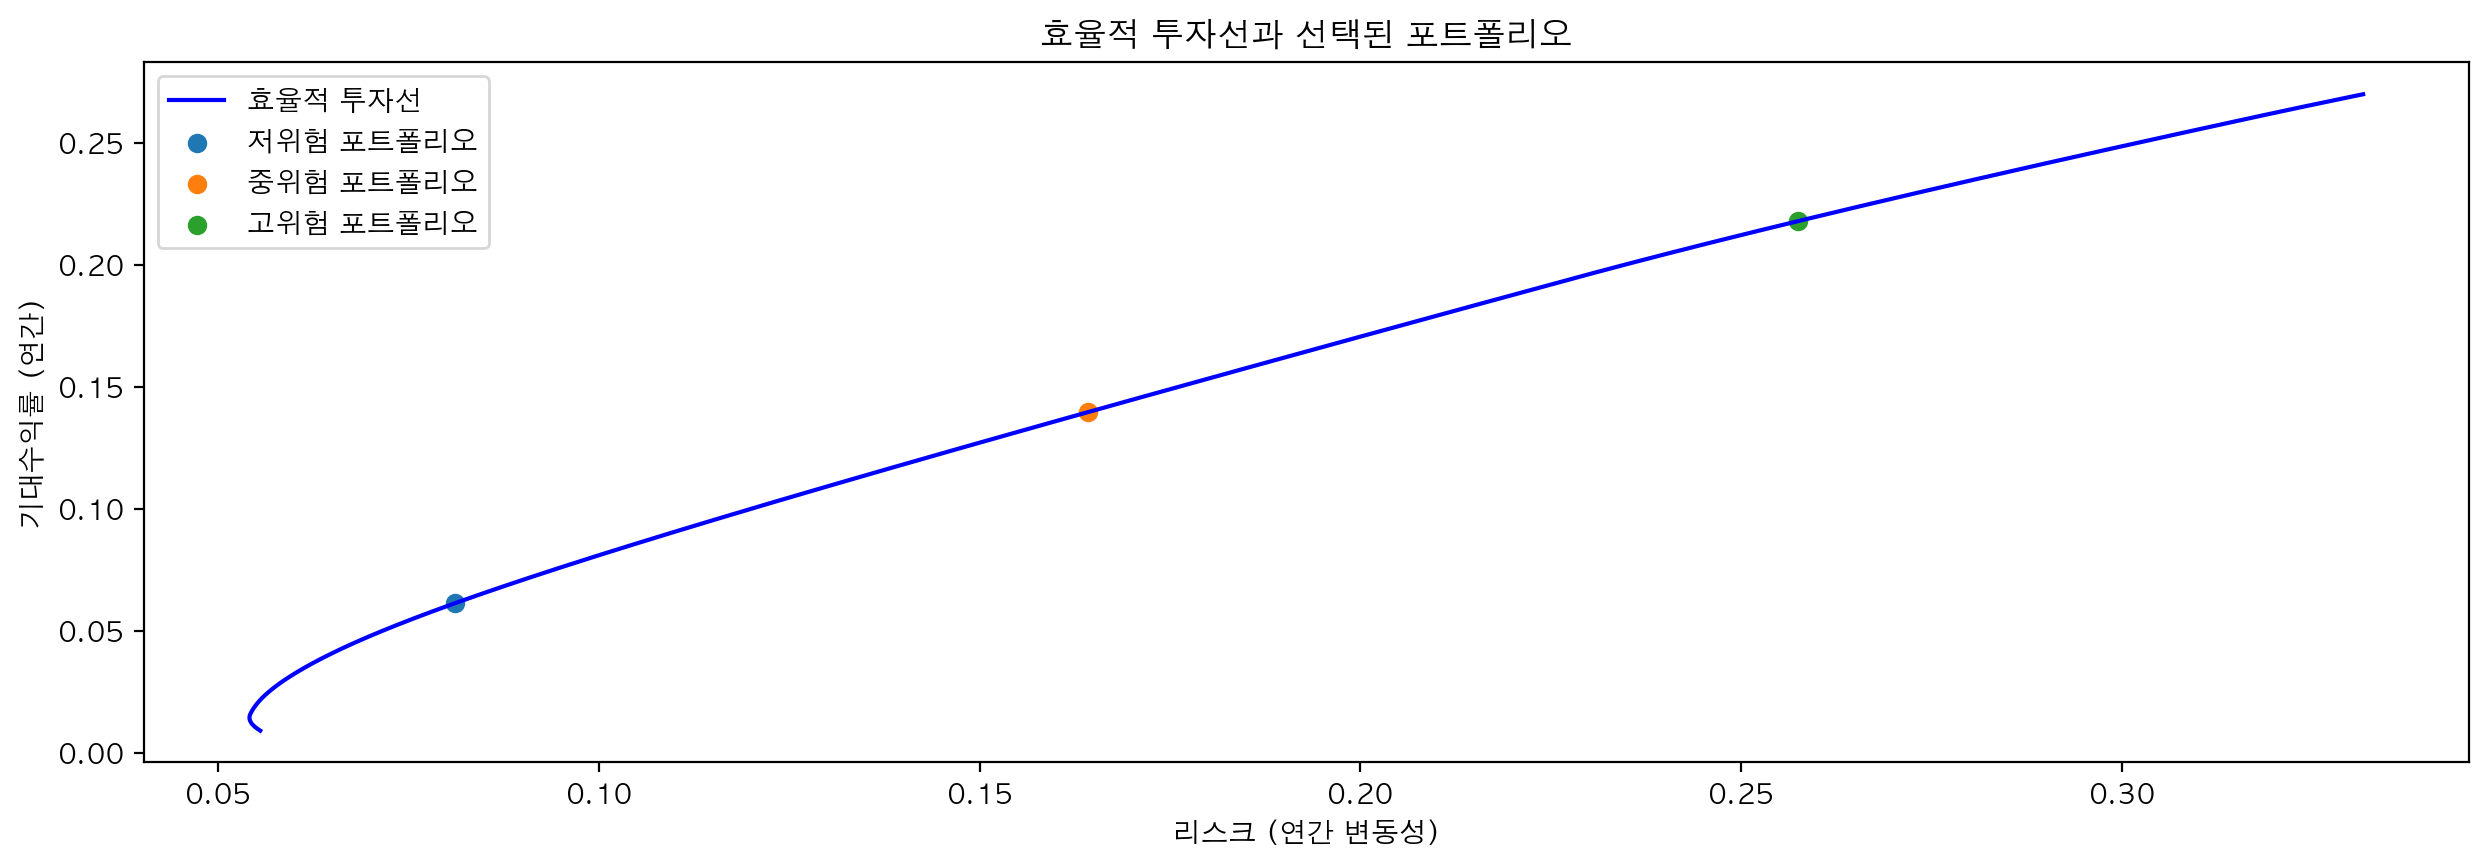

In [17]:
# 효율적 투자선과 선택된 포트폴리오 시각화
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(risk_array, returns_array, 'b-', label='효율적 투자선')
for risk_level, portfolio in portfolios.items():
    plt.scatter(portfolio['risk'], portfolio['return'], 
               marker='o', label=f'{risk_level} 포트폴리오')
plt.xlabel('리스크 (연간 변동성)')
plt.ylabel('기대수익률 (연간)')
plt.title('효율적 투자선과 선택된 포트폴리오')
plt.legend()

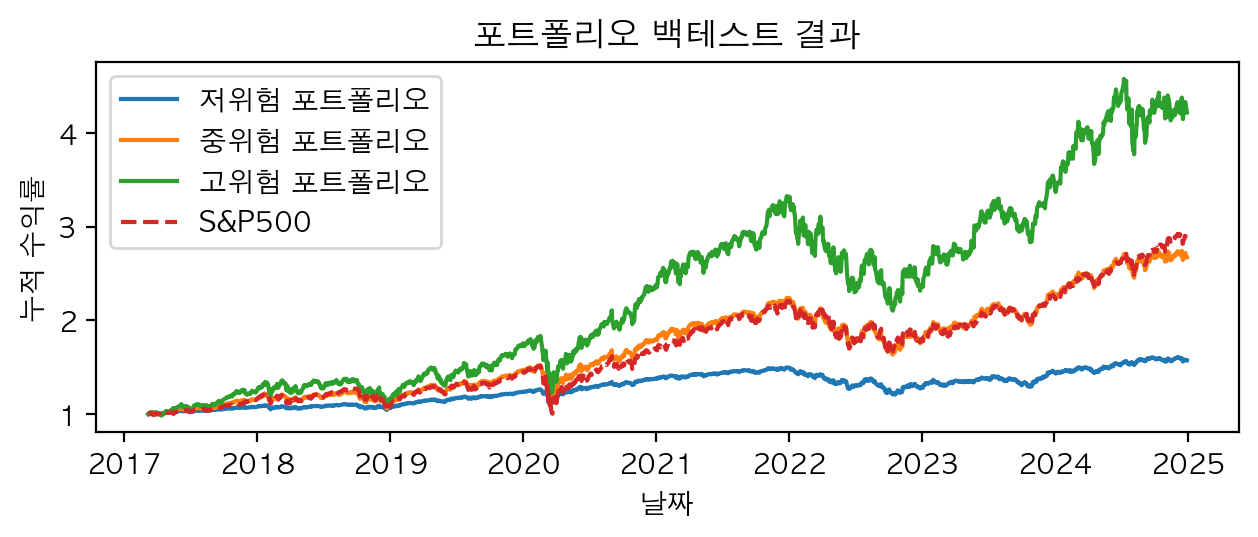

In [18]:
# 백테스트 결과 시각화
plt.subplot(2, 1, 2)
for risk_level, portfolio in portfolios.items():
    plt.plot(portfolio['backtest'], label=f'{risk_level} 포트폴리오')
plt.plot(spy_cumulative, label='S&P500', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.title('포트폴리오 백테스트 결과')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# 결과 출력
print("\n== 포트폴리오 분석 결과 ==")
for risk_level, portfolio in portfolios.items():
    final_return = portfolio['backtest'][-1]
    spy_final_return = spy_cumulative[-1]
    outperformance = (final_return - spy_final_return) * 100
    
    print(f"\n{risk_level} 포트폴리오:")
    print(f"연간 기대수익률: {portfolio['return']:.2f}%")
    print(f"연간 리스크: {portfolio['risk']:.2f}%")
    print(f"S&P500 대비 초과성과: {outperformance:.2f}%")
    print("\n자산 배분:")
    for ticker, weight in zip(tickers, portfolio['weights']):
        if weight > 0.01:  # 1% 이상인 비중만 출력
            print(f"{ticker}: {weight*100:.1f}%")
            


== 포트폴리오 분석 결과 ==

저위험 포트폴리오:
연간 기대수익률: 0.06%
연간 리스크: 0.08%
S&P500 대비 초과성과: -126.53%

자산 배분:
SPY: 23.6%
MBB: 69.2%
SOXX: 7.2%

중위험 포트폴리오:
연간 기대수익률: 0.14%
연간 리스크: 0.16%
S&P500 대비 초과성과: -16.38%

자산 배분:
SPY: 47.4%
MBB: 28.3%
SOXX: 24.2%

고위험 포트폴리오:
연간 기대수익률: 0.22%
연간 리스크: 0.26%
S&P500 대비 초과성과: 138.25%

자산 배분:
SPY: 43.2%
SOXX: 56.2%


/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_27173/2488209058.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_return = portfolio['backtest'][-1]
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_27173/2488209058.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_final_return = spy_cumulative[-1]


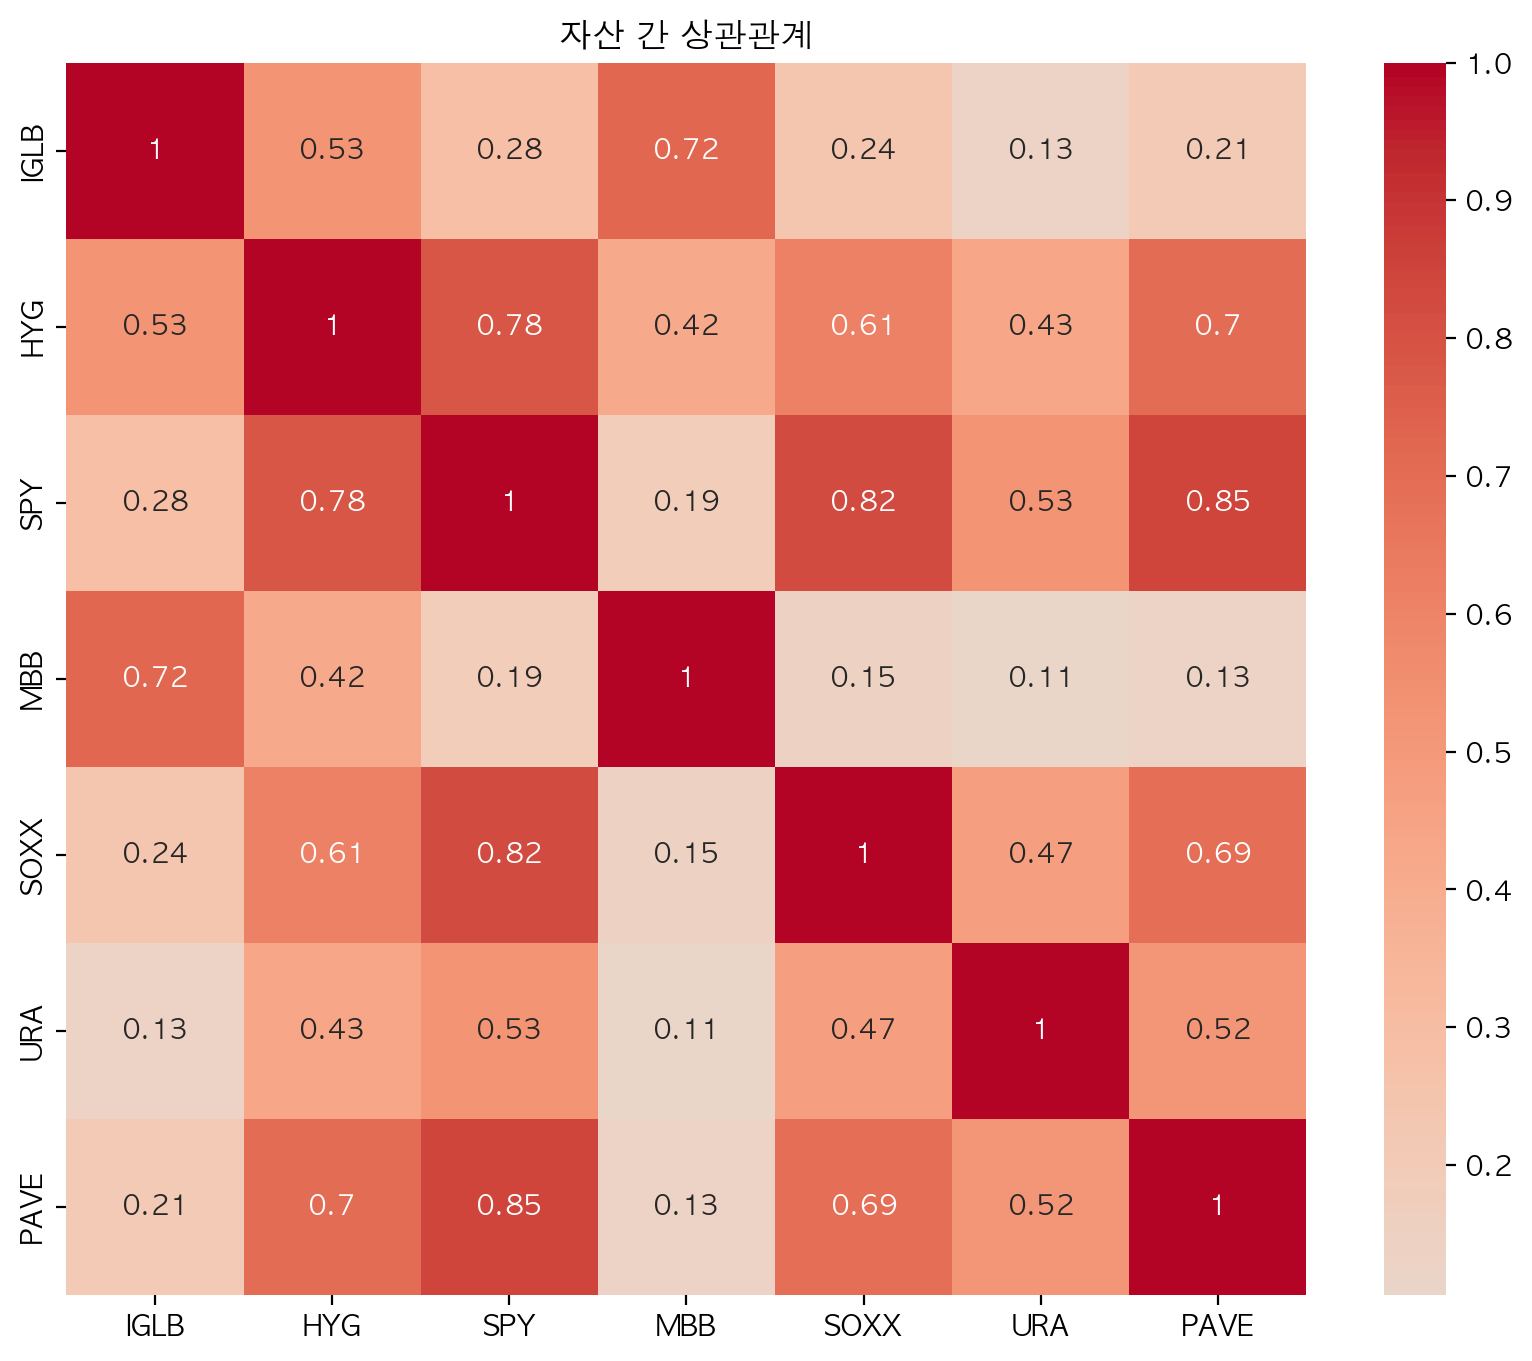

In [20]:
# 상관관계 분석 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('자산 간 상관관계')
plt.show()